In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
%matplotlib inline

Old Trivers model: Initial differences feedbacking to greater differences. Initial anisogamy leads to further sex differentiation. Since the female cares more from the beginning, she keeps caring more. The same for male competing, it feedbacks into more competition.
But this is a verbal model. These claims must be carefully confirmed by evidence. Mathematical models are a proposed way to provide evidence from mechanistic considerations.

Kokko and Jennions previously devised a model for that purpose. Their model shows a force in opposition to the amplification of differences: when the operational sex ratio is male-biased, males have no incentive to desert caring, since they will have to compete for mates (strange... it depends on efficiency of caring and competition). They conclude that, apart from other differences, sex roles are stable against anisogamy (not necessarily, even; it seems...). Other differences include: stronger sexual selection on one sex, mixed parentage, biased adult sex ratio).
Argument of this article: the opposing force conclusion is wrong. With an updated model, the article corrects the wrong assumptions. The effects of those other factors for sex differences remain similar.
The article also shows that previous arguments for direct causal role of ASR in parental investment are misleading; and clarifies how the fisher condition aplies to the different measures of sex ratios, at birth, at maturation, at adulthood, and mating pool ratio(fisher condition is a consistency requirement: each mating with offspring involves 1 male and 1 female, so offspring comes in 1:1 ratio, it's an ESS).

Variables. Male vars are with underscore ($u_i$ is female and $\tilde{u_i}$ is male).
Two states of individuals: time-in (i), seeking mate; time-out (o), providing care.

$T$ = care duration, duration of time-out.

$n$ = number of individuals per breeding attempt. monandry: $n = \tilde{n} = 1$. polyandry: $n = 1, \tilde{n} > 1$.

$k$ = strength of sexual selection; to account for intra/inter sexual selection. separates individuals of a sex into two subpopulations, $1/k$ of them, at maturation, is able to mate and then care, and the rest is not.

$u_i$, $u_o$ = mortality rate during time-in and time-out.

$x$ = competitiveness, models the investment in traits for fitness that decrease longevity.

$r$ = maturation sex ratio (MSR), individuals entering time-in for the first time.

$M$ = mate search coefficient, account for species specific factor such as population density and movement capacity. (the constant factor of the mating rate $a$)

$\alpha$ = shape coefficient of brood survival function ***more info***

$\gamma$ = synergy coefficient, coefficient for effect of care with both parents present.

$\tau$ = expected care duration per brood.

$a$ = mating rate (of individuals qualified to mate), number of mates per time, $a = Mn\sqrt{r_o}$ ; $ \tilde{a} = M \tilde{n}/\sqrt{r_o} $; fisher condition imposes $a/\tilde{a} = r_on/\tilde{n}$. ***justify, why roots? fisher?***

$p$ = probability to survive a given time-in period, $p = a/(a+u_i)$ ***why?***.

$s$ = probability to survive a given time-out period, $s = e^{-Tu_o}$, calculated from bottom left of 9.

$b$ = brood size, how many individuals on average come from a mate.

$S$ = brood survival, probability of offspring come to maturation and time-in. $S(\tau_{total}) = e^{-\alpha/\tau_{total}}$, with $\tau_{total} = n\tau + \tilde{n} \tilde{\tau}$, with $\tau(T) = T - \int_0^T e^{-tu_o}u_o(T-t)dt = (1-e^{u_oT})/u_o$. Total time minus the mean time of no-care because of death during time-out.

$W$ = fitness of average individual. expected number of mates in a lifetime * offspring per mate * fraction of offspring surviving until maturation. also, the contribution comes from $(1/k)$ of the population, with $1-(1/k)$ contributing with $W=0$. so $W = (1/k) * p/(1-sp) * b * S$. and $\tilde{W} = (1/\tilde{k}) * \tilde{p}/(1-\tilde{s}\tilde{p}) * b * S * (n/\tilde{n})$ to account for the rate of real paternity. Calculated in eqs 1,2.

$r_o$ = operational sex ratio (OSR), ratio of individuals in time-in, in the mating pool.

$r_a$ = adult sex ratio (ASR), all matured individuals, in time-in and time-out

The null version of the updated model retains all key assumptions of the previous model from Kokko and Jennions.

In [69]:
# Deterministic solution function

def Deterministic(step, dt, parameters, initial_state):
    # Calculates the deterministic solution of the model at time steps*dt
    # Inputs the number of time steps covered by the solution, the infinitesimal time dt,
    # the parameters of the model, and the initial state of species
    # Outputs an array of time steps, an array of the solution phi(t=steps*dt), and
    # the deterministic solution function to be used in other computations
    
    # Initialize outputs
    phi0_t = []
    phi1_t = []
    time = [] 
    
    # Model function, with the differential system
    def model(t,y,parameters):
        
        uo = parameters[0]
        ui = parameters[1]
        uo_ = parameters[2]
        ui_ = parameters[3]
        k = parameters[4]
        n = parameters[5]
        M = parameters[6]
        r = parameters[7]
        alpha = parameters[8]

        # Moving parameters:
        k_ = parameters[9]
        n_ = parameters[10]
        
        # Synergy model parameter:
        gamma = parameters[11]
        
        # S
        tau = (1-np.exp(-uo*y[0]))/uo
        tau_ = (1-np.exp(-uo_*y[1]))/uo_
        theta = n*n_*(tau+tau_)**2/4
        tausy = (1+gamma*n*n_*tau*tau_/theta)
        taut = (n*tau+n_*tau_)*tausy
        S = np.exp(-alpha/taut)

        dtautS = alpha*np.exp(-alpha/taut)/taut**2
        dttau = np.exp(-uo*y[0])
        dtautaut = 1 + gamma*n_*tau_*(2*n*tau+n_*tau_)/theta # in the models, this lacks dtaut/dtau; simple = n
        dtS = dtautS*dttau*dtautaut

        dttau_ = np.exp(-uo_*y[1])
        dtautaut_ = 1 + gamma*n*tau*(2*n_*tau_+n*tau)/theta # in the models, this lacks the dtaut/dtau; simple = n_
        dtS_ = dtautS*dttau_*dtautaut_

        # s
        s = np.exp(-uo*y[0])
        dts = -uo*np.exp(-uo*y[0])

        s_ = np.exp(-uo_*y[1])
        dts_ = -uo_*np.exp(-uo_*y[1])

        # p
        A = n*r*(1-np.exp(-uo*y[0]))*k/k_ - n_*(1-np.exp(-uo_*y[1]))
        ro = r*k*ui/(k_*ui_) + (M*M*A/(2*ui_*ui_))*(A+np.sqrt(A*A+4*ui*ui_*r*k/(M*M*k_))) # +- sqrt

        a = M*n*ro**(1/2)
        a_ = M*n_*ro**(-1/2)
        p = a/(a+ui)
        p_ = a_/(a_+ui_)


        # Equations of motion
        dT = dtS/S + p*dts/(1-p*s)
        dT_ = dtS_/S + p_*dts_/(1-p_*s_)

        return[dT,dT_]
    
    # Solution time
    iter_time = [x*dt for x in range(step)]
    
    # Solution object and solve
    J = ode_solver()
    J.function = model
    J.ode_solve(y_0=initial_state, t_span=iter_time, params=parameters)
    sol = J.solution
    
    # Take solutions
    for i in range(len(sol)):
        time.append(sol[i][0])
        phi0_t.append(sol[i][1][0])
        phi1_t.append(sol[i][1][1])
    
    phi_t = [np.array(phi0_t), np.array(phi1_t)]
    
#    x = np.zeros(len(phi_t[0]))
#    for i in range(len(phi_t[0])):
#        if phi_t[0][i] < 0 or phi_t[1][i] < 0:
#            x[i] = 1
#    phi_t[0] = phi_t[0][x.astype('bool')]
#    phi_t[1] = phi_t[1][x.astype('bool')]
    
    return np.array(time), phi_t, J

In [62]:
#gamma, n, tau, n_, tau_ = var('gamma, n, tau, n_, tau_')
#theta = n*n_*(tau+tau_)**2/4
#eq = (n*tau+n_*tau_)*(1+gamma*n*n_*tau*tau_/theta)
#diff(eq,tau)

n*(4*gamma*tau*tau_/(tau + tau_)^2 + 1) + 4*(n*tau + n_*tau_)*(gamma*tau_/(tau + tau_)^2 - 2*gamma*tau*tau_/(tau + tau_)^3)

In [70]:
# Constant parameters:
uo = 0.01
ui = 0.01
uo_ = 0.01
ui_ = 0.01
k = 1
n = 1
M = 1
r = 1
alpha = 0.1

steps = 100

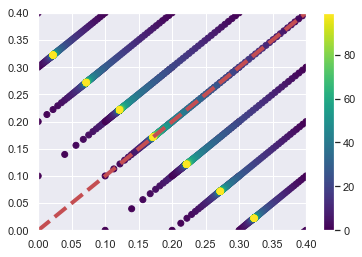

In [71]:
### Solution 1: n_ = 1, k_ = 1

#Moving parameters:
k_ = 1
n_ = 1
gamma = 0

parameters = [uo, ui, uo_, ui_, k, n, M, r, alpha, k_, n_, gamma]

# Initial Values
To = []
for i in range(5):
    for j in range(5):
        To.append([i/10,j/10])
del To[0]



# Capture solutions
solutions = []
for i in range(len(To)):
    time, X, _ = Deterministic(steps, 0.01, parameters, To[i])
    solutions.append([time, X])
    
    
# Plot graphic    
color = np.arange(steps)
for i in range(len(To)):
    plt.scatter(solutions[i][1][0],solutions[i][1][1], c=color, cmap='viridis')
    plt.xlim((0,0.4))
    plt.ylim((0,0.4))
    #plt.plot(T[-1], T_[-1], 'D',c='green',markersize=10)
    #plt.plot(T[0], T_[0], '+',c='green',markersize=20)
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1), '--', linewidth=4, c='r')
plt.colorbar()

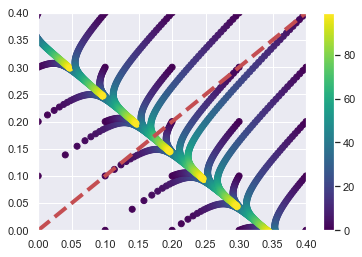

In [72]:
### Solution 2: n_ = 1, k_ = 1.2

# Moving parameters:
k_ = 1.2
n_ = 1
gamma = 0

parameters = [uo, ui, uo_, ui_, k, n, M, r, alpha, k_, n_, gamma]

# Initial Values
To = []
for i in range(5):
    for j in range(5):
        To.append([i/10,j/10])
del To[0]



# Capture solutions
solutions = []
for i in range(len(To)):
    time, X, _ = Deterministic(steps, 0.01, parameters, To[i])
    solutions.append([time, X])


# Plot graphic    
color = np.arange(steps)
for i in range(len(To)):
    plt.scatter(solutions[i][1][0],solutions[i][1][1], c=color, cmap='viridis')
    plt.xlim((0,0.4))
    plt.ylim((0,0.4))
    #plt.plot(T[-1], T_[-1], 'D',c='green',markersize=10)
    #plt.plot(T[0], T_[0], '+',c='green',markersize=20)
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1), '--', linewidth=4, c='r')
plt.colorbar()

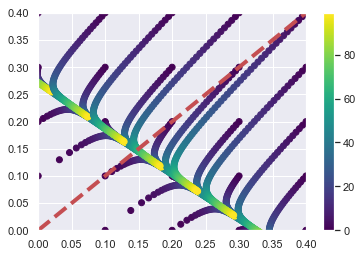

In [73]:
### Solution 3: n_ = 1.2, k_ = 1

# Moving parameters:
k_ = 1
n_ = 1.2
gamma = 0

parameters = [uo, ui, uo_, ui_, k, n, M, r, alpha, k_, n_, gamma]

# Initial Values
To = []
for i in range(5):
    for j in range(5):
        To.append([i/10,j/10])
del To[0]



# Capture solutions
solutions = []
for i in range(len(To)):
    time, X, _ = Deterministic(steps, 0.01, parameters, To[i])
    solutions.append([time, X])


# Plot graphic    
color = np.arange(steps)
for i in range(len(To)):
    plt.scatter(solutions[i][1][0],solutions[i][1][1], c=color, cmap='viridis')
    plt.xlim((0,0.4))
    plt.ylim((0,0.4))
    #plt.plot(T[-1], T_[-1], 'D',c='green',markersize=10)
    #plt.plot(T[0], T_[0], '+',c='green',markersize=20)
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1), '--', linewidth=4, c='r')
plt.colorbar()

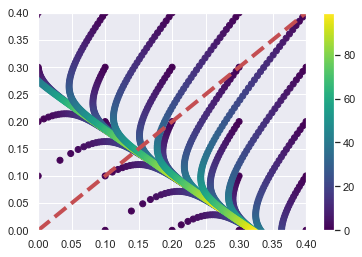

In [74]:
### Solution 4: n_ = 1.2, k_ = 1.2

# Moving parameters:
k_ = 1.2
n_ = 1.2
gamma = 0

parameters = [uo, ui, uo_, ui_, k, n, M, r, alpha, k_, n_, gamma]

# Initial Values
To = []
for i in range(5):
    for j in range(5):
        To.append([i/10,j/10])
del To[0]



# Capture solutions
solutions = []
for i in range(len(To)):
    time, X, _ = Deterministic(steps, 0.01, parameters, To[i])
    solutions.append([time, X])


# Plot graphic    
color = np.arange(steps)
for i in range(len(To)):
    plt.scatter(solutions[i][1][0],solutions[i][1][1], c=color, cmap='viridis')
    plt.xlim((0,0.4))
    plt.ylim((0,0.4))
    #plt.plot(T[-1], T_[-1], 'D',c='green',markersize=10)
    #plt.plot(T[0], T_[0], '+',c='green',markersize=20)
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1), '--', linewidth=4, c='r')
plt.colorbar()

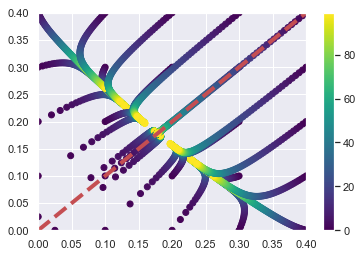

In [79]:
### Solution 1: n_ = 1, k_ = 1 SYNERGY

#Moving parameters:
k_ = 1
n_ = 1
gamma = 0.1

parameters = [uo, ui, uo_, ui_, k, n, M, r, alpha, k_, n_, gamma]

# Initial Values
To = [[0.025,0],[0,0.025]]
for i in range(5):
    for j in range(5):
        To.append([i/10,j/10])
del To[2]



# Capture solutions
solutions = []
for i in range(len(To)):
    time, X, _ = Deterministic(steps, 0.01, parameters, To[i])
    solutions.append([time, X])
    
    
# Plot graphic    
color = np.arange(steps)
for i in range(len(To)):
    plt.scatter(solutions[i][1][0],solutions[i][1][1], c=color, cmap='viridis')
    plt.xlim((0,0.4))
    plt.ylim((0,0.4))
    #plt.plot(T[-1], T_[-1], 'D',c='green',markersize=10)
    #plt.plot(T[0], T_[0], '+',c='green',markersize=20)
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1), '--', linewidth=4, c='r')
plt.colorbar()

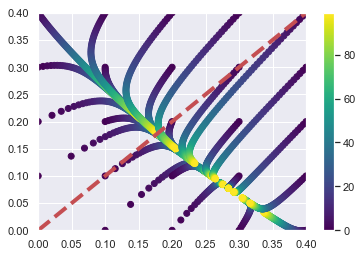

In [76]:
### Solution 2: n_ = 1, k_ = 1.2 SYNERGY

# Moving parameters:
k_ = 1.2
n_ = 1
gamma = 0.1

parameters = [uo, ui, uo_, ui_, k, n, M, r, alpha, k_, n_, gamma]

# Initial Values
To = []
for i in range(5):
    for j in range(5):
        To.append([i/10,j/10])
del To[0]



# Capture solutions
solutions = []
for i in range(len(To)):
    time, X, _ = Deterministic(steps, 0.01, parameters, To[i])
    solutions.append([time, X])


# Plot graphic    
color = np.arange(steps)
for i in range(len(To)):
    plt.scatter(solutions[i][1][0],solutions[i][1][1], c=color, cmap='viridis')
    plt.xlim((0,0.4))
    plt.ylim((0,0.4))
    #plt.plot(T[-1], T_[-1], 'D',c='green',markersize=10)
    #plt.plot(T[0], T_[0], '+',c='green',markersize=20)
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1), '--', linewidth=4, c='r')
plt.colorbar()

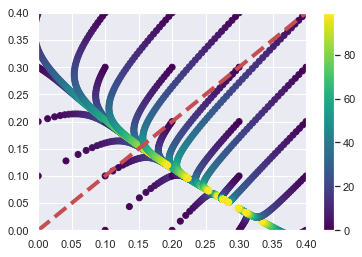

In [77]:
### Solution 3: n_ = 1.2, k_ = 1 SYNERGY

# Moving parameters:
k_ = 1
n_ = 1.2
gamma = 0.1

parameters = [uo, ui, uo_, ui_, k, n, M, r, alpha, k_, n_, gamma]

# Initial Values
To = []
for i in range(5):
    for j in range(5):
        To.append([i/10,j/10])
del To[0]



# Capture solutions
solutions = []
for i in range(len(To)):
    time, X, _ = Deterministic(steps, 0.01, parameters, To[i])
    solutions.append([time, X])


# Plot graphic    
color = np.arange(steps)
for i in range(len(To)):
    plt.scatter(solutions[i][1][0],solutions[i][1][1], c=color, cmap='viridis')
    plt.xlim((0,0.4))
    plt.ylim((0,0.4))
    #plt.plot(T[-1], T_[-1], 'D',c='green',markersize=10)
    #plt.plot(T[0], T_[0], '+',c='green',markersize=20)
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1), '--', linewidth=4, c='r')
plt.colorbar()

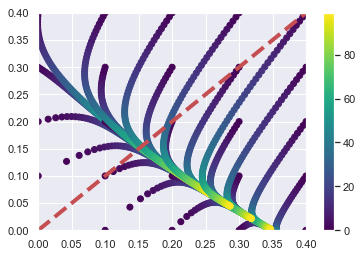

In [78]:
### Solution 4: n_ = 1.2, k_ = 1.2 SYNERGY

# Moving parameters:
k_ = 1.2
n_ = 1.2
gamma = 0.1

parameters = [uo, ui, uo_, ui_, k, n, M, r, alpha, k_, n_, gamma]

# Initial Values
To = []
for i in range(5):
    for j in range(5):
        To.append([i/10,j/10])
del To[0]



# Capture solutions
solutions = []
for i in range(len(To)):
    time, X, _ = Deterministic(steps, 0.01, parameters, To[i])
    solutions.append([time, X])


# Plot graphic    
color = np.arange(steps)
for i in range(len(To)):
    plt.scatter(solutions[i][1][0],solutions[i][1][1], c=color, cmap='viridis')
    plt.xlim((0,0.4))
    plt.ylim((0,0.4))
    #plt.plot(T[-1], T_[-1], 'D',c='green',markersize=10)
    #plt.plot(T[0], T_[0], '+',c='green',markersize=20)
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1), '--', linewidth=4, c='r')
plt.colorbar()

In [26]:
# INCOMPLETE CODE

# Kokko Jennions - 2008

# Constant parameters:
uo = 0.01
ui = 0.01
uo_ = 0.01
ui_ = 0.01
k = 1
n = 1
M = 1
r = 1
alpha = 0.1

# Moving parameters:
k_ = 1
n_ = 1

# Initialize variables
T = [.3]
T_ = [.3]

for i in range(500):
    
    
        # S
    taut = n*T[i]+n_*T_[i]
    S = np.exp(-alpha/taut)
    dS = alpha*np.exp(-alpha/taut)/taut**2

    # p
    A = n*r*(1-np.exp(-uo*T[i])) - n_*(1-np.exp(-uo_*T_[i]))
    ro = r*ui/ui_ + (M*M*A/(2*ui_*ui_))*(A-np.sqrt(A*A+4*ui*ui_*r/(M*M))) # +- sqrt


    # Equations of motion
    dT = dS/n - S*M*k*np.sqrt(ro) + ui - uo
    dT_ = dS/n_ - S*M*k_/np.sqrt(ro) + ui_ - uo_
    
    # Update
    sT = T[-1]+dT
    sT_ = T_[-1]+dT_
    
    T.append(sT)
    T_.append(sT_)

In [16]:
# Deterministic solution function

def Deterministic(step, dt, parameters, initial_state):
    # Calculates the deterministic solution of the model at time steps*dt
    # Inputs the number of time steps covered by the solution, the infinitesimal time dt,
    # the parameters of the model, and the initial state of species
    # Outputs an array of time steps, an array of the solution phi(t=steps*dt), and
    # the deterministic solution function to be used in other computations
    
    # Initialize outputs
    phi0_t = []
    phi1_t = []
    time = [] 
    
    # Model function, with the differential system
    def model(t,y,parameters):
        alpha = parameters[0]
        T = y[0]+y[1]
        return[np.exp(-alpha/T)*(alpha/T**2 - 1),np.exp(-alpha/T)*(alpha/T**2 - 1)]
    
    # Solution time
    iter_time = [x*dt for x in range(step)]
    
    # Solution object and solve
    J = ode_solver()
    J.function = model
    J.ode_solve(y_0=initial_state, t_span=iter_time, params=parameters)
    sol = J.solution
    
    # Take solutions
    for i in range(len(sol)):
        time.append(sol[i][0])
        phi0_t.append(sol[i][1][0])
        phi1_t.append(sol[i][1][1])
    
    phi_t = [np.array(phi0_t), np.array(phi1_t)]    
    
    return np.array(time), phi_t, J